### Imports & data Directory

In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from natsort import natsorted, ns
from skimage import io, color

%matplotlib inline

In [3]:
#Directory
data = 'HPTLCRaw\\'

### Grey Scale Import

##### Import Images as Grey Scale

In [4]:
list_files = os.listdir(data)
list_files = natsorted(list_files)
image_list = []
for filename in list_files:
    image_list.append(color.rgb2gray(io.imread(data+filename)[:,:,:3]))

##### Crop all Images

In [5]:
cropped_img_list = []
for image in image_list:
    cropped_img_list.append(image[70:1100,96:-84])

##### Plot Every Cropped File as a Greyscale Image

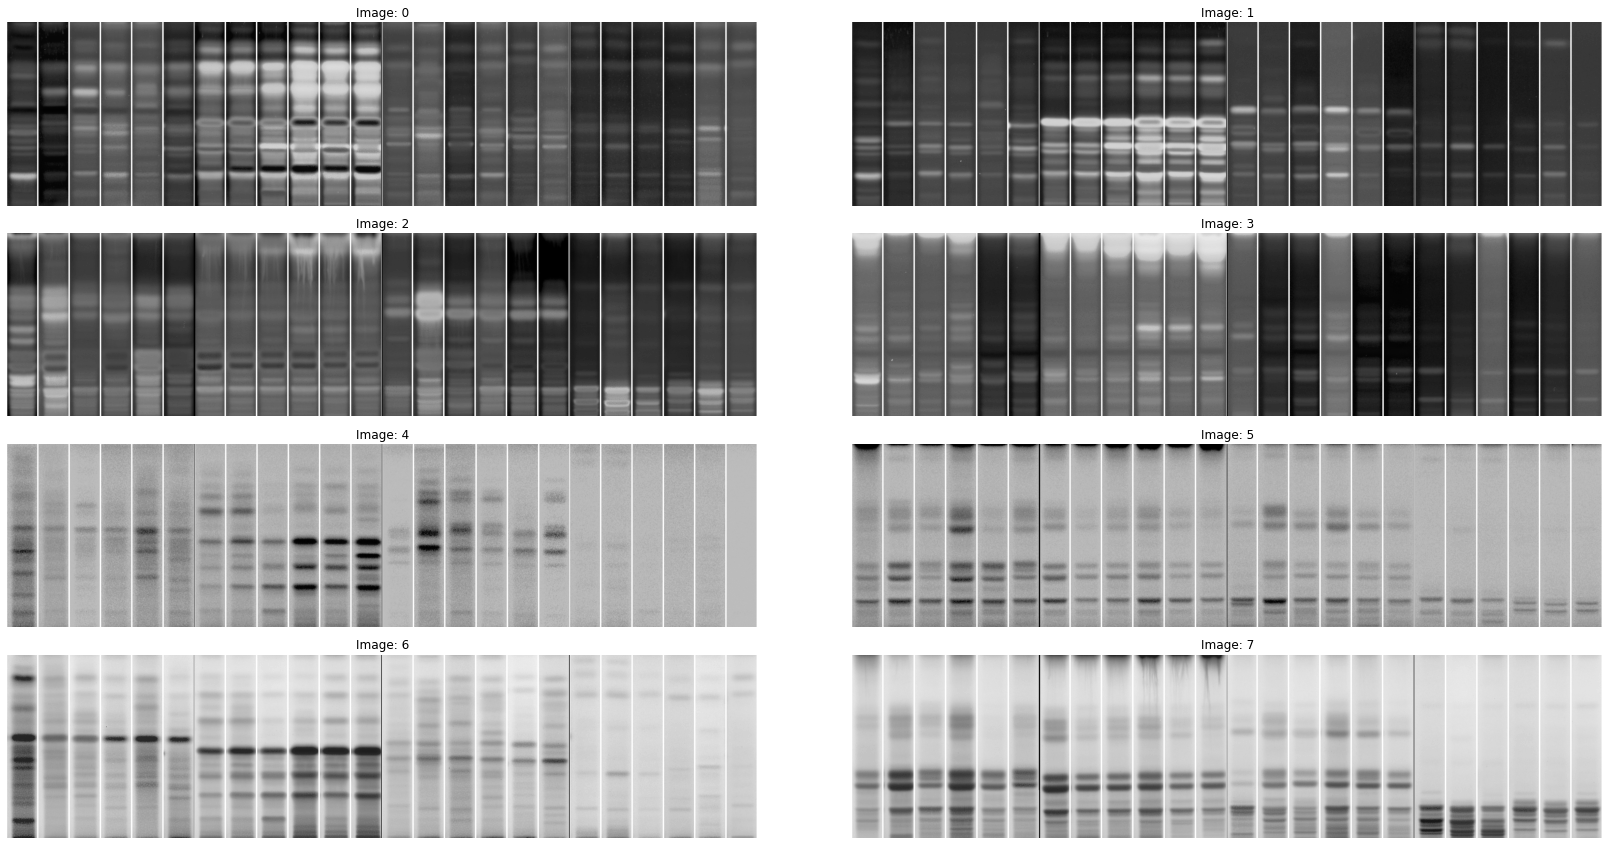

In [6]:
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(cropped_img_list):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    sub.set_title('Image: '+str(i))
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=.15)

##### Verifying Shape of each Cropped Image


In [7]:
for i in range(len(cropped_img_list)):
    print(np.shape(cropped_img_list[i]))

(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)


### Algorithm to determine crop locations

In [8]:
def det_crop_locations(ar):
    maxVal = ar.max()
    res = []
    res.append([0,0])
    n = len(ar)

    i = 10
    while i < len(ar-5):
        # While we are within bounds and
        # we have not found a peak or
        # haven't yet travelled at least 100 pixels or
        # are not within 5% of the max value
        # increment i
        while (i < n-5) and (not (ar[i] >= ar[i-1] and ar[i] >= ar[i+1]) or not (i - res[-1][0] > 100) or not(ar[i] > (.85*maxVal))):
            i += 1

        #if we reach the end of the image, break the loop
        if i >= n-5:
            break

        # Add Back wall of single strip to q
        res[-1][1] = i - 15
        
        #Add front wall to q
        res.append([i + 15,0])
        
    #remove last appended crop as it is at the end of the image and therefore not useful
    res.pop()
    return res

#### Use Function to Determine Crop Locations of Each Image

In [9]:
crops_list = []
for cropped_img in cropped_img_list:
    temp = pd.DataFrame(cropped_img)
    temp_hi_cnt = temp[temp>.8].count()
    temp_low_cnt = temp[temp==0].count()
    temp_cnt = temp_hi_cnt + temp_low_cnt
    crops_list.append(det_crop_locations(temp_cnt.copy()))

In [10]:
# Verify Number of Crops for Each Image
for crops in crops_list:
    print(len(crops))

24
24
24
24
24
24
24
24


##### Generate Plot of Crop Locations for all Images -> Common Sense Check Reasonability of Algorithm Results

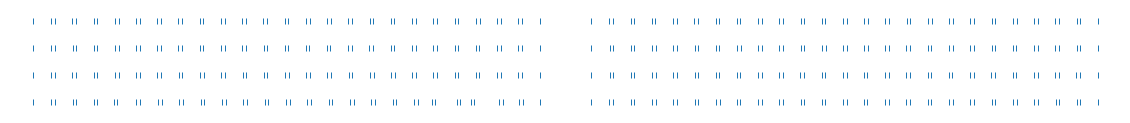

In [11]:
fig = plt.figure(figsize=(20, 2))
for i, crops in enumerate(crops_list):
    temp = pd.DataFrame(crops).to_numpy().flatten()
    sub = fig.add_subplot(4,2,i+1)
    sub.axis('off')
    sub.plot(temp,np.zeros_like(temp),'|')
plt.tight_layout
fig.subplots_adjust(wspace=.001, hspace=0)

##### Cropping Images and adding Individual Slices to new Array

In [12]:
multiview_strip_array = []

#For every View
for i, cropped_image in enumerate(cropped_img_list):
    min_width = float('inf')
    strip_array = []

    #First find the minimum width of all the crops
    for crop in crops_list[i]:
        front, back = crop
        min_width = min(min_width,back-front)

    #Get half of that min width
    min_width_half = int((min_width-2)/2)

    #For each of the crops, crop them from their own midpoint +- the mind_width_half value
    for crop in crops_list[i]:
        front, back = crop
        strip_mid = int(back/2 + front/2)
        min_front = strip_mid - min_width_half
        min_back = min_width_half + strip_mid
        strip_array.append(cropped_image[:,min_front:min_back])

    multiview_strip_array.append(strip_array)

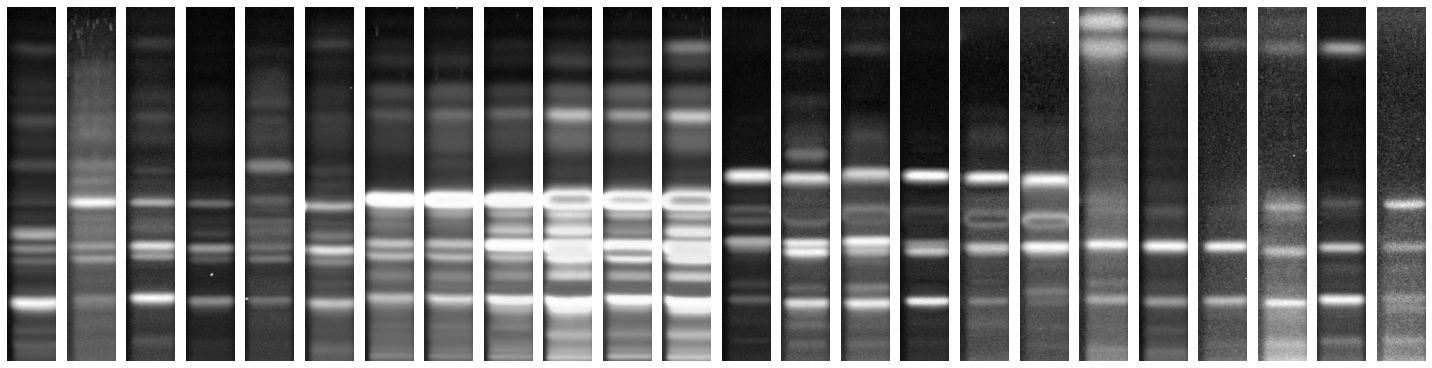

In [13]:
# Individual Print
# strip_array = strip_array_list[1]
strip_array = multiview_strip_array[1]
fig = plt.figure(figsize=(20, 10))
for i, strip in enumerate(strip_array):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    sub.imshow(strip,cmap='gray')
plt.tight_layout()

### Transforming each Strip in array to a 1D Vector by getting average value of each row

In [14]:
multiview_strip_row_avg_list = []

for strip_array in multiview_strip_array:
    strip_row_avg = []

    for i, strip in enumerate(strip_array):
        strip_row_avg.append([])
        for row in strip:
            strip_row_avg[i].append(row.mean())

    multiview_strip_row_avg_list.append(strip_row_avg)

In [15]:
np.shape(multiview_strip_row_avg_list[0][0])

(1030,)

In [16]:
np.shape(np.transpose([multiview_strip_row_avg_list[0][i] for k in range(min_width)]))

(1030, 140)

#### Plotting arrays of average values to verify mean of each row

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

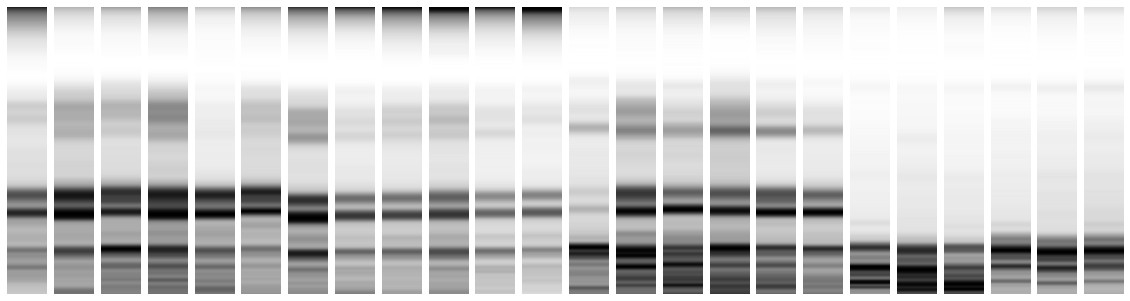

In [17]:
# Individual
fig = plt.figure(figsize=(20, 10)) 
for i in range(24):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    img = [multiview_strip_row_avg_list[-1][i] for k in range(min_width)]
    img = np.transpose(img)
    sub.imshow(img, cmap='gray')
plt.tight_layout

### Setting up Target Values & Dictionary Mapping

In [18]:
# 1 (GG): Rows 1 - 6 
# 2 (GI): Rows 7 - 12
# 3 (GU): Rows 13 - 18
# 4 (GE): Rows 19 - 21
# 5 (GL): Rows 22 - 24
map = {1:'GG',2:'GI',3:'GU',4:'GE',5:'GL'}
print(map[4])

GE


In [19]:
np.shape(multiview_strip_row_avg_list)

(8, 24, 1030)

In [20]:
np.shape(multiview_strip_row_avg_list[0])

(24, 1030)

In [21]:
#Done for the purposes of appending all views into 1 long feature vector later
no_targets_multiview_strip_row_avg_list = np.array(multiview_strip_row_avg_list).copy()

##### Append Targets to feature array

In [22]:
for strip_row_avg in multiview_strip_row_avg_list:
    for i in range(6):
        # strip_row_avg[i].append(1)
        strip_row_avg[i] = np.append(strip_row_avg[i],1)
    for i in range(6,12):
        # strip_row_avg[i].append(2)
        strip_row_avg[i] = np.append(strip_row_avg[i],2)
    for i in range(12,18):
        # strip_row_avg[i].append(3)
        strip_row_avg[i] = np.append(strip_row_avg[i],3)
    for i in range(18,21):
        # strip_row_avg[i].append(4)
        strip_row_avg[i] = np.append(strip_row_avg[i],4)
    for i in range(21,24):
        # strip_row_avg[i].append(5)
        strip_row_avg[i] = np.append(strip_row_avg[i],5)

In [23]:
#Verifying Shape of Multiview Multi-Dimensional Array
print(np.shape(multiview_strip_row_avg_list))

(8, 24, 1031)


In [24]:
# Verifying values are w/n the 0 - 1 range
print(np.shape(multiview_strip_row_avg_list[0][0]))
print(max(multiview_strip_row_avg_list[0][0]))
print(min(multiview_strip_row_avg_list[0][0]))

(1031,)
1.0
0.046075564761115705


### RUN EVERYTHING ABOVE THIS
---

In [25]:
print('Run Above')

Run Above


---
#### Conclusion from V1.1: Even though it has a greater depth, the model with Max Depth = 4 and N_estimators = 20 has fewer leaves.

## Get the Encoding for every Sample on every Tree in every View

### Save mapping of resulting Trees to Number of Leaves in aformentioned Tree for each original feature vector (strip)

In [26]:
multiViewInputLeafEncoding = []
multiViewTreeLeafCountMap = {} #NEW
#Train the model per view
for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = RandomForestClassifier()

    #Set Model Parameters
    model.set_params(n_estimators=20,
                    max_depth=4,
                    random_state=101)

    #Train Model
    model.fit(df_feat,df_target)

    #Get Every Tree in forest
    everyTree = [estimator for estimator in model.estimators_]

    #####Get leaf indicies of sample applied to each tree in forest
    leafResultIndxs = model.apply(df_feat)

    #####Gets the indexes of the leaves for every tree
    ##### AND mapping for number of leaves per tree
    indxOfLeavesEveryTree = []
    singleViewTreeLeafCountMap = {}
    for k, tree in enumerate(everyTree):
        #Array where each node has the number of its left children BUT leaves have -1
        allChildren = tree.tree_.children_left
        #Get all leaves
        indxOfLeaves = np.where(allChildren == -1)[0]
        indxOfLeavesEveryTree.append(list(indxOfLeaves))

        #AddMapping
        singleViewTreeLeafCountMap[tree] = tree.tree_.n_leaves
        
    #####Get the encoding for each tree in a single view
    singleViewInputLeafEncoding = []
    #For every strip's row of resulting leaf indexes,
    for stripLeafResultIndxs in leafResultIndxs:
        #Create an array to save each tree's encoding to
        singleStripLeafEncoding = []
        #For every resulting leaf index in that row
        for treeNum, treeLeafResultIndex in enumerate(stripLeafResultIndxs):
            #Create the encoding for that tree
            treeLeafEncoding = [int(x == treeLeafResultIndex) for x in indxOfLeavesEveryTree[treeNum]]
            singleStripLeafEncoding.append(treeLeafEncoding.copy())
        #Append the encoding for that tree after flattening
        singleViewInputLeafEncoding.append(np.concatenate(singleStripLeafEncoding.copy()).ravel())

    #Append the encoding created for a view to a list of all the views
    multiViewInputLeafEncoding.append(singleViewInputLeafEncoding)
    multiViewTreeLeafCountMap[i] = singleViewTreeLeafCountMap

In [27]:
print(np.shape(multiViewInputLeafEncoding))

(8, 24)


c:\Python39\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


#### Save Encodings to CSV

In [28]:
for i, oneViewInputLeafEncoding in enumerate(multiViewInputLeafEncoding):
    tempStr = 'treeLeafEncodingData/leafEncodingView'+str(i+1)+'.csv'
    np.savetxt(tempStr, np.asarray(oneViewInputLeafEncoding), delimiter=',')

#### Reminder about how to iterate through Dictionary
Dictionary Format:

    * key = tree object
    * value = n_leaves

In [29]:
for key in multiViewTreeLeafCountMap[0]:
    print(key)
    print(multiViewTreeLeafCountMap[0][key])

DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=70431583)
5
DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=225658379)
7
DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=303514961)
6
DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                       random_state=1944264518)
5
DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=122295871)
5
DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                       random_state=2080686679)
4
DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=736679933)
6
DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=5713995)
5
DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=795758575)
6
DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=146505097)
5
DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                       random_state=1434076109)
7
DecisionTreeClassi